In [1]:
# Set up sys.path and import needed packages.
import _preamble

import numpy as np
import matplotlib.pyplot as plt

from pmte import estimation, tapers, util
import helpers

In [2]:
# Set basic parameters.
N = 128  # Size of images
M = 1000  # Number of images
W = 1 / 8  # Bandwidth

# Initialize PRNG.
rng = np.random.default_rng(0)

In [3]:
# Load a set of clean simulated projection images.
clean = helpers.load_sim_images(M)

In [4]:
# Define a power spectral density (PSD) and use this to generate noise that we
# add to the images.

psd_fun = lambda x, y: np.exp(-np.hypot(x, y) ** 2 / (2 * 0.125 ** 2))

psd_true = psd_fun(*util.grid((N, N), shifted=True))

noise = helpers.generate_field((N, N), M, psd_fun=psd_fun, rng=rng, dtype=clean.dtype)

signal = 10 * clean + noise

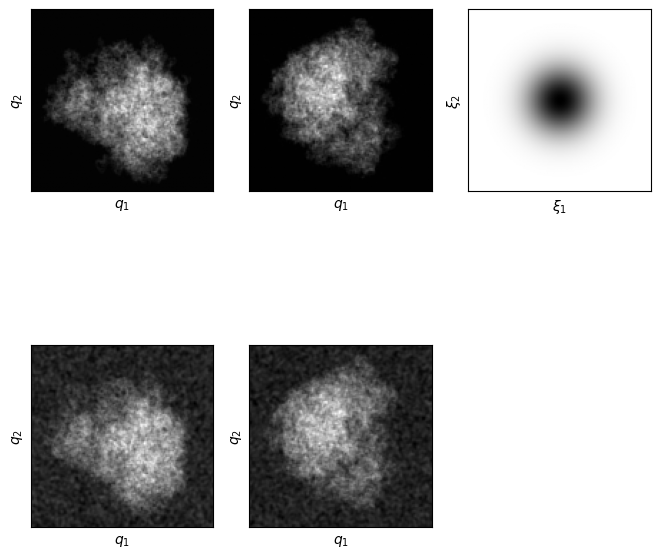

In [5]:
# Plot Figure 9 in the paper.
plt.figure(figsize=(8, 8))
plt.subplot(231)
helpers.plot_grayscale_image(clean[0], diverging=False, reverse=False)

plt.subplot(232)
helpers.plot_grayscale_image(clean[1], diverging=False, reverse=False)

plt.subplot(233)
helpers.plot_grayscale_image(psd_true, diverging=False, axis="\\xi")

plt.subplot(234)
helpers.plot_grayscale_image(signal[0], diverging=False, reverse=False)

plt.subplot(235)
helpers.plot_grayscale_image(signal[1], diverging=False, reverse=False)

plt.show(block=False)

In [6]:
# Create a sample disk complement mask and generate the corresponding corner
# mask (by generating tensor tapers for the corners and extracting their support).

mask_sample = ~helpers.disk_mask(N, 60)

corner_tapers = tapers.corner_tapers(mask_sample, W)
corner_mask_sample = np.any(np.abs(corner_tapers) > 0, axis=0)

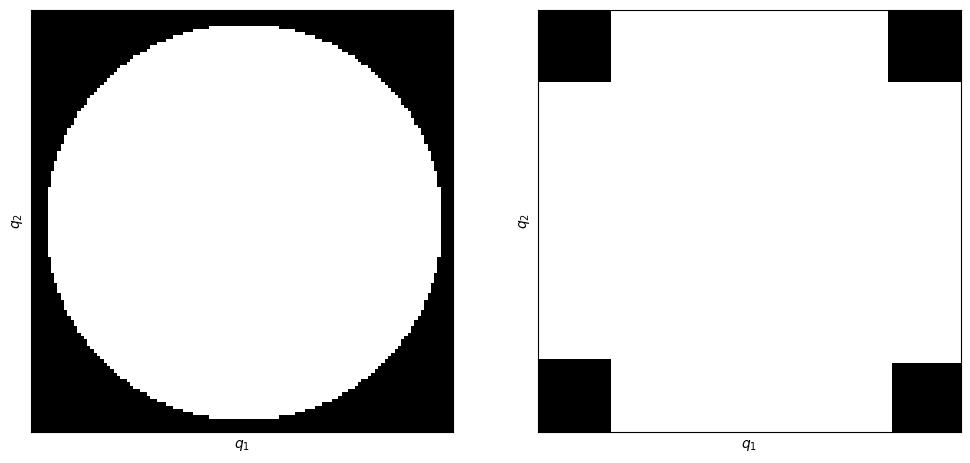

In [7]:
# Plot Figure 10(a,b) in the paper.
plt.figure(figsize=(12, 8))

plt.subplot(121)
helpers.plot_grayscale_image(mask_sample, diverging=False)

plt.subplot(122)
helpers.plot_grayscale_image(corner_mask_sample, diverging=False)

plt.show(block=False)

In [8]:
# Define functions for estimating the density using the three methods for a
# given mask.


def est_mper(x, mask):
    x_mper = estimation.periodogram(x * mask, 2, shifted=True)
    x_mper *= N ** 2 / np.sum(mask)

    return x_mper


def est_pmt(x, mask):
    h_pmt = tapers.proxy_tapers(mask, W, rng=rng)
    x_pmt = estimation.multitaper(x, h_pmt, shifted=True)

    return x_pmt


def est_cmt(x, mask):
    h_cmt = tapers.corner_tapers(mask, W)
    x_cmt = estimation.multitaper(x, h_cmt, shifted=True)

    return x_cmt

In [9]:
# Estimate the density for masks corresponding to various radii. From these, we
# compute the mean squared error (MSE), squared bias, and variance of the
# density estimates.

radii = np.arange(36, 72 + 1, 4)

methods = {"mper": est_mper, "cmt": est_cmt, "pmt": est_pmt}

sq_biases = {name: [] for name in methods}
variances = {name: [] for name in methods}
mses = {name: [] for name in methods}

print("%-20s%8s%15s%15s%15s" % ("Method", "Radius", "Bias^2", "Variance", "MSE"))

for radius in radii:
    mask = ~helpers.disk_mask(N, radius)

    for name, method in methods.items():
        psd_est = method(signal, mask)

        sq_bias = np.mean(np.abs(np.mean(psd_est, axis=0) - psd_true) ** 2)
        variance = np.mean(np.abs(psd_est - np.mean(psd_est, axis=0)) ** 2)
        mse = np.mean(np.abs(psd_est - psd_true) ** 2)

        print("%-20s%8d%15e%15e%15e" % (name, radius, sq_bias, variance, mse))

        mses[name].append(mse)
        sq_biases[name].append(sq_bias)
        variances[name].append(variance)

Method                Radius         Bias^2       Variance            MSE
mper                      36   3.859159e+02   8.733346e+01   4.732493e+02
cmt                       36   2.493990e+00   5.274647e-01   3.021454e+00
pmt                       36   2.887393e+01   2.211932e+00   3.108586e+01
mper                      40   9.614100e+01   3.628968e+01   1.324307e+02
cmt                       40   6.006992e-01   2.331405e-01   8.338395e-01
pmt                       40   1.011193e+01   1.376526e+00   1.148846e+01
mper                      44   1.851068e+01   1.149698e+01   3.000766e+01
cmt                       44   1.014728e-01   8.885565e-02   1.903285e-01
pmt                       44   2.896846e+00   6.562412e-01   3.553087e+00
mper                      48   2.535456e+00   2.613326e+00   5.148783e+00
cmt                       48   1.220471e-02   2.271642e-02   3.492116e-02
pmt                       48   5.708463e-01   2.092495e-01   7.800960e-01
mper                      52   1.62460

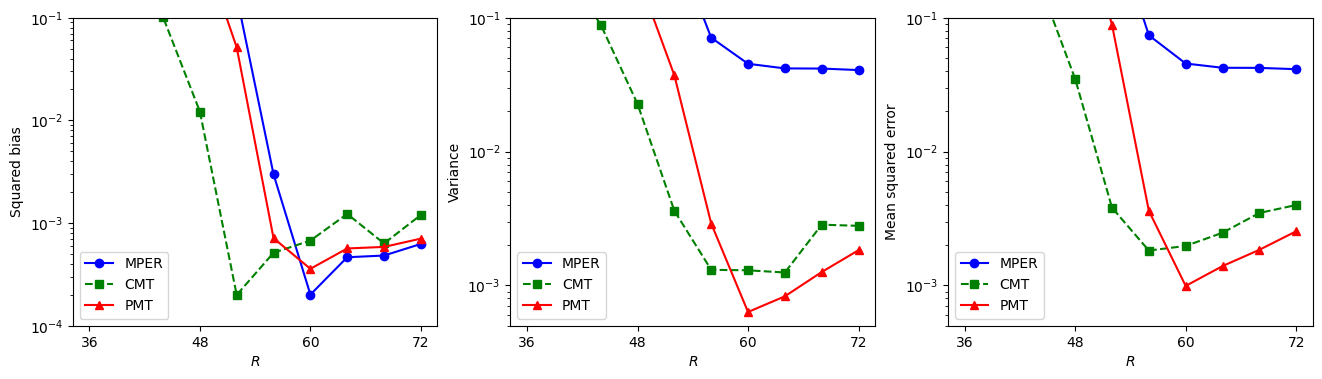

In [10]:
# Plot Figure 10(c,d,e) in the paper.
plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.semilogy(
    radii,
    sq_biases["mper"],
    "o-b",
    radii,
    sq_biases["cmt"],
    "s--g",
    radii,
    sq_biases["pmt"],
    "^-r",
)
plt.legend(("MPER", "CMT", "PMT"), loc="lower left")
plt.ylim((1e-4, 1e-1))
plt.xticks([36, 48, 60, 72])
plt.xlabel("$R$")
plt.ylabel("Squared bias")

plt.subplot(132)
plt.semilogy(
    radii,
    variances["mper"],
    "o-b",
    radii,
    variances["cmt"],
    "s--g",
    radii,
    variances["pmt"],
    "^-r",
)
plt.legend(("MPER", "CMT", "PMT"), loc="lower left")
plt.ylim((5e-4, 1e-1))
plt.xticks([36, 48, 60, 72])
plt.xlabel("$R$")
plt.ylabel("Variance")

plt.subplot(133)
plt.semilogy(
    radii, mses["mper"], "o-b", radii, mses["cmt"], "s--g", radii, mses["pmt"], "^-r"
)
plt.legend(("MPER", "CMT", "PMT"), loc="lower left")
plt.ylim((5e-4, 1e-1))
plt.xticks([36, 48, 60, 72])
plt.xlabel("$R$")
plt.ylabel("Mean squared error")
plt.show(block=False)

In [11]:
# Extract some useful metrics from the data and print them.
min_variance_mper = np.min(variances["mper"])
min_variance_cmt = np.min(variances["cmt"])
min_variance_pmt = np.min(variances["pmt"])

variance_factor_mper = min_variance_mper / min_variance_pmt
variance_factor_cmt = min_variance_cmt / min_variance_pmt

print("Variance reduction vs. masked periodogram: %f" % (variance_factor_mper,))
print("Variance reduction vs. corner multitaper: %f" % (variance_factor_cmt,))

min_mse_mper = np.min(mses["mper"])
min_mse_cmt = np.min(mses["cmt"])
min_mse_pmt = np.min(mses["pmt"])

mse_factor_mper = min_mse_mper / min_mse_pmt
mse_factor_cmt = min_mse_cmt / min_mse_pmt

print("MSE reduction vs. masked periodogram: %f" % (mse_factor_mper,))
print("MSE reduction vs. corner multitaper: %f" % (mse_factor_cmt,))

Variance reduction vs. masked periodogram: 64.169426
Variance reduction vs. corner multitaper: 1.972438
MSE reduction vs. masked periodogram: 41.611963
MSE reduction vs. corner multitaper: 1.837529


---

In [12]:
# Save data for figure generation.
helpers.save_image("cryo_sim_sig1", clean[0])
helpers.save_image("cryo_sim_sig2", clean[1])
helpers.save_image("cryo_sim_sig_noise1", signal[0])
helpers.save_image("cryo_sim_sig_noise2", signal[1])
helpers.save_image("cryo_sim_psd", psd_true)

helpers.save_image("cryo_sim_mask", mask_sample)
helpers.save_image("cryo_sim_mask_grid", corner_mask_sample)

helpers.save_table(
    "cryo_sim_biases",
    np.round(radii),
    sq_biases["mper"],
    sq_biases["cmt"],
    sq_biases["pmt"],
)

helpers.save_table(
    "cryo_sim_variances",
    np.round(radii),
    variances["mper"],
    variances["cmt"],
    variances["pmt"],
)

helpers.save_table(
    "cryo_sim_mses", np.round(radii), mses["mper"], mses["cmt"], mses["pmt"]
)

results = {
    "min_mse_rt": float(min_mse_pmt),
    "mse_factor_mper": float(mse_factor_mper),
    "mse_factor_cmt": float(mse_factor_cmt),
    "variance_factor_mper": float(variance_factor_mper),
    "variance_factor_cmt": float(variance_factor_cmt),
}

helpers.save_dictionary("cryo_sim", results)